# Example of asynchronous requests (v > 1.1)
- The scope of this example is to show how to request several products together so that internal resource usage is maximized
- We extract the spectrum of the Crab in groups of 'nscw' science windows for each semester from 'start_year' to 'stop_year' included
- We fit the spectra with a broken power law using xspec

In [9]:
#A few input parameters
osa_version="OSA10.2"
source_name="Crab"
nscw=10
start_year=2004
end_year=2006
oda_platform="staging"
systematic_fraction = 0.01
token=''

In [2]:
#You can provide a valid token as explained in the 'Authentication' example or skip this cell
import getpass
token = getpass.getpass('Insert the token')

Insert the token········


In [10]:
#Example of functions to select a science window list
import time

import astroquery.heasarc
from astropy.coordinates import SkyCoord
from astropy import units as u

Heasarc = astroquery.heasarc.Heasarc()



def get_scw_list(ra_obj, dec_obj,radius,start_date,end_date ):
    R = Heasarc.query_region(
            position = SkyCoord(ra_obj, dec_obj, unit='deg'), 
            radius = f"{radius} deg",
            mission = 'intscw',                 
            time = start_date + " .. " + end_date,
            good_isgri = ">1000",
        )        

    R.sort('SCW_ID')

    return R['SCW_ID'], R['SCW_VER']


assert astroquery.__version__ >= '0.4.2.dev6611'

# it means it's our fork
assert 'isdc' in astroquery.heasarc.Conf.server.cfgtype

In [11]:
import numpy as np
from astroquery.simbad import Simbad
from astropy import coordinates as coord

import json

import os
import shutil
import random

from astropy.io import fits

from scipy import stats
result_table = Simbad.query_object(source_name)
source_coord = coord.SkyCoord(result_table['RA'][0], result_table['DEC'][0], unit=("hourangle", "deg"))
ra=source_coord.ra.deg
dec=source_coord.dec.deg
radius=8.

#We hardcode a catalog for the Crab
api_cat={
    "cat_frame": "fk5", 
    "cat_coord_units": "deg", 
    "cat_column_list": [
        [0, 7], 
        ["1A 0535+262", "Crab"], 
        [125.4826889038086, 1358.7255859375], 
        [84.72280883789062, 83.63166809082031], 
        [26.312734603881836, 22.016284942626953], 
        [-32768, -32768], 
        [2, 2], 
        [0, 0], 
        [0.0002800000074785203, 0.0002800000074785203]], 
    "cat_column_names": [
        "meta_ID", 
        "src_names", 
        "significance", 
        "ra", 
        "dec", 
        "NEW_SOURCE", 
        "ISGRI_FLAG", 
        "FLAG", 
        "ERR_RAD"
    ], 
    "cat_column_descr": 
        [
            ["meta_ID", "<i8"], 
            ["src_names", "<U11"], 
            ["significance", "<f8"], 
            ["ra", "<f8"], 
            ["dec", "<f8"], 
            ["NEW_SOURCE", "<i8"], 
            ["ISGRI_FLAG", "<i8"], 
            ["FLAG", "<i8"], 
            ["ERR_RAD", "<f8"]
        ], 
    "cat_lat_name": "dec", 
    "cat_lon_name": "ra"
}



In [12]:
#Different instances of the platform, the first two are available only internally

import oda_api.api

import oda_api

from pkg_resources import parse_version

assert parse_version(oda_api.__version__) > parse_version("1.1.0")


def dispatcher(_oda_platform):
    disp = oda_api.api.DispatcherAPI(
        url = {
            'staging' : 'http://dispatcher.staging.internal.odahub.io',
            'staging-1-3': 'http://in.internal.odahub.io/staging-1-3/dispatcher',
            'staging-1-2': 'http://cdcihn.isdc.unige.ch/staging-1.2/dispatcher',
            'production-1-2': 'https://www.astro.unige.ch/cdci/astrooda/dispatch-data',
        }[_oda_platform]
    )
    disp.get_instrument_description("isgri")
    return disp

if oda_platform == 'auto':
    # osa versions with '-' use ic root version, only available on staging-1-3
    print('will find appropriate API for OSA version', osa_version)

    if '-' in osa_version:
        print('osa version has subversion - will use staging-1-3')
        disp = dispatcher('staging-1-3')        
    else:
        try:
            disp = dispatcher('staging-1-2')        
            print('will use staging-1-2')
        except Exception as e:
            print('\033[31mFAILED to access staging-1-2, will proceed to query production: note that it can not access private data!\033[0m')
            print('\033[31mexception was: ', e,'\033[0m')
            try:
                disp = dispatcher('production-1-2')
            except:
                raise ConnectionError
else:
    print("custom platform selection:", oda_platform)
    disp = dispatcher(oda_platform)

    
    print("selected", disp.url)

custom platform selection: staging


unable to dig list, instance not a dict by <class 'list'>; object was [{'query_name': 'src_query'}, {'name': 'src_name', 'units': 'str', 'value': 'test'}, {'name': 'RA', 'units': 'deg', 'value': 0.0}, {'name': 'DEC', 'units': 'deg', 'value': 0.0}, {'name': 'T1', 'units': None, 'value': '2001-12-11T00:00:00.000'}, {'name': 'T2', 'units': None, 'value': '2001-12-11T00:00:00.000'}, {'name': 'token', 'units': 'str', 'value': None}]
unable to dig list, instance not a dict by <class 'list'>; object was [{'query_name': 'isgri_parameters'}, {'name': 'user_catalog', 'units': 'str', 'value': None}, {'name': 'scw_list', 'units': 'names_list', 'value': []}, {'name': 'selected_catalog', 'units': 'str', 'value': None}, {'name': 'radius', 'units': 'deg', 'value': 5.0}, {'name': 'max_pointings', 'units': None, 'value': 50}, {'name': 'osa_version', 'units': 'str', 'value': None}, {'name': 'integral_data_rights', 'units': 'str', 'value': 'public'}, {'name': 'E1_keV', 'units': 'keV', 'value': 10.0}, {'na

selected http://dispatcher.staging.internal.odahub.io


In [13]:
#Here, we collect and save spectra for each year and semester

spectrum_results=[]

disp_by_ys = {}
data_by_ys = {}

par_dict = {'instrument':'isgri',
          'product': 'isgri_spectrum',
          'osa_version' : osa_version,
          'product_type': 'Real',         
          'selected_catalog' : json.dumps(api_cat)}

if token != '':
    par_dict.update({'token': token})

while True:
    spectrum_results=[]

    for year in range(start_year, end_year+1): 
        for semester in [1,2]:
            if semester ==1:
                T1_utc='%4d-01-01 00:00:00.0'%year
                T2_utc='%4d-06-30 23:59:59.0'%year # there are 30 days in June!
            else:
                T1_utc='%4d-07-01 00:00:00.0'%year
                T2_utc='%4d-12-31 23:59:59.0'%year 

            print(T1_utc,'-',T2_utc)

            scwlist, version = get_scw_list(ra, dec,radius, T1_utc, T2_utc)
            
            print(scwlist)
            
            if len(scwlist) == 0:
                raise Exception('No science windows in %d semester %d'%(year,semester))

            scw_pick = [(s+"."+v).strip() for s,v in zip(scwlist,version)]
                 
            if nscw >0 and len(scw_pick)>=nscw:
                random.seed(0)
                scw_pick = random.sample(scw_pick, nscw)
            
            scw_list_str = ",".join(sorted(scw_pick))
            
            #print("We analyze these scws: ", scw_list_str)
            
            if '-' not in osa_version:
                if year >= 2016:
                    osa_version='OSA11.0'
                else:
                    osa_version='OSA10.2'
                    
            ys = (year, semester)

            if ys not in disp_by_ys:
                disp_by_ys[ys] = oda_api.api.DispatcherAPI(url=disp.url, wait=False)
            
            _disp = disp_by_ys[ys]

            data = data_by_ys.get(ys, None)
            
            par_dict.update({'scw_list': scw_list_str})
            
            if data is None and not _disp.is_failed:
                data = _disp.get_product(**par_dict)
                
                data_by_ys[ys] = data

#                 if not _disp.is_complete:
#                     continue

                if not _disp.is_submitted:
                    data = _disp.get_product(**par_dict)
                else:
                    _disp.poll()

                
                print("Is complete", _disp.is_complete)
                if not _disp.is_complete:
                    continue
                else:
                    data = _disp.get_product(**par_dict)

            # This part saves the spectra in fits files and updates some keywords
            
            for ID,s in enumerate(data._p_list):
                if (s.meta_data['src_name']==source_name):
                    if(s.meta_data['product']=='isgri_spectrum'):
                        ID_spec=ID
                    if(s.meta_data['product']=='isgri_arf'):
                        ID_arf=ID
                    if(s.meta_data['product']=='isgri_rmf'):
                        ID_rmf=ID

            print(ID_spec, ID_arf, ID_rmf)

            spec=data._p_list[ID_spec].data_unit[1].data
            arf=data._p_list[ID_arf].data_unit[1].data
            rmf=data._p_list[ID_rmf].data_unit[2].data
            expos=data._p_list[0].data_unit[1].header['EXPOSURE']
            name=source_name+'_'+str(year)+'_%d'%semester
            specname=name+'_spectrum.fits'
            arfname=name+'_arf.fits.gz'
            rmfname=name+'_rmf.fits.gz'
            data._p_list[ID_spec].write_fits_file(specname)
            data._p_list[ID_arf].write_fits_file(arfname)
            data._p_list[ID_rmf].write_fits_file(rmfname)
            hdul = fits.open(specname, mode='update')
            hdul[1].header.set('EXPOSURE', expos)
            hdul[1].header['RESPFILE']=rmfname
            hdul[1].header['ANCRFILE']=arfname
            hdul[1].data['SYS_ERR']=systematic_fraction

            hdul.close()


            spectrum_results.append(data)
        
    n_complete = len([ year for year, _disp in disp_by_ys.items() if _disp.is_complete ])
    print(f"complete {n_complete} / {len(disp_by_ys)}")
    if n_complete == len(disp_by_ys):
        print("done!")
        break
    print("not done")


2004-01-01 00:00:00.0 - 2004-06-30 23:59:59.0
   SCW_ID   
------------
017000370010
017000380010
017000380020
017000380030
017000390010
017000400010
017000410010
017000420010
017000690010
017000700010
         ...
017000890010
017000900010
017000910010
017000920010
017000930010
017000940010
017000950010
017000960010
017700160010
017700170010
018100050010
Length = 39 rows
Is complete False
2004-07-01 00:00:00.0 - 2004-12-31 23:59:59.0
   SCW_ID   
------------
022500120010
022500130010
022500140010
022900500010
023900020010
023900020020
023900030010
023900040010
023900050010
023900060010
         ...
023900920010
023900930010
023900940010
023900950010
023900960010
023900970010
023900980010
023900990010
023901000010
024200100010
024200110010
Length = 101 rows


Is complete False
2005-01-01 00:00:00.0 - 2005-06-30 23:59:59.0
   SCW_ID   
------------
030000040010
030000050010
030000060010
030000070010
030000080010
030000090010
030000100010
030000110010
030000120010
030000130010
         ...
030000210010
030000220010
030000230010
030000240010
030000250010
030000260010
030000270010
030000280010
030100140010
030100150010
030800040010
Length = 28 rows


Is complete False
2005-07-01 00:00:00.0 - 2005-12-31 23:59:59.0
   SCW_ID   
------------
035200040010
035200050010
035200060010
035200070010
035200080010
035200090010
035200100010
035200110010
035200120010
035200130010
         ...
036500960010
036500970010
036500980010
036500990010
036501000010
036501010010
036501020010
036501030010
036501040010
036501040020
037200190010
Length = 86 rows


Is complete False
2006-01-01 00:00:00.0 - 2006-06-30 23:59:59.0
   SCW_ID   
------------
042000140010
042200020010
042200030010
042200040010
042200050010
042200060010
042200070010
042200080010
042200090010
042200100010
         ...
042201060010
042201070010
042201080010
042201090010
042201100010
042201110010
042201120010
042201120020
042201120030
042800690010
042800700010
Length = 114 rows


Is complete False
2006-07-01 00:00:00.0 - 2006-12-31 23:59:59.0
   SCW_ID   
------------
046800040010
046800050010
048300410010
048300410020
048300410030
048300420010
048300420020
048300420030
048300430010
048300430020
         ...
048300580010
048300590010
048300600010
048300610010
048300620010
048300630010
048300640010
048300650010
048300660010
048300670010
048300680010
Length = 34 rows


Is complete False
complete 0 / 6
not done
2004-01-01 00:00:00.0 - 2004-06-30 23:59:59.0
   SCW_ID   
------------
017000370010
017000380010
017000380020
017000380030
017000390010
017000400010
017000410010
017000420010
017000690010
017000700010
         ...
017000890010
017000900010
017000910010
017000920010
017000930010
017000940010
017000950010
017000960010
017700160010
017700170010
018100050010
Length = 39 rows


Is complete False
2004-07-01 00:00:00.0 - 2004-12-31 23:59:59.0
   SCW_ID   
------------
022500120010
022500130010
022500140010
022900500010
023900020010
023900020020
023900030010
023900040010
023900050010
023900060010
         ...
023900920010
023900930010
023900940010
023900950010
023900960010
023900970010
023900980010
023900990010
023901000010
024200100010
024200110010
Length = 101 rows


Is complete False
2005-01-01 00:00:00.0 - 2005-06-30 23:59:59.0
   SCW_ID   
------------
030000040010
030000050010
030000060010
030000070010
030000080010
030000090010
030000100010
030000110010
030000120010
030000130010
         ...
030000210010
030000220010
030000230010
030000240010
030000250010
030000260010
030000270010
030000280010
030100140010
030100150010
030800040010
Length = 28 rows


Is complete False
2005-07-01 00:00:00.0 - 2005-12-31 23:59:59.0
   SCW_ID   
------------
035200040010
035200050010
035200060010
035200070010
035200080010
035200090010
035200100010
035200110010
035200120010
035200130010
         ...
036500960010
036500970010
036500980010
036500990010
036501000010
036501010010
036501020010
036501030010
036501040010
036501040020
037200190010
Length = 86 rows


Is complete False
2006-01-01 00:00:00.0 - 2006-06-30 23:59:59.0
   SCW_ID   
------------
042000140010
042200020010
042200030010
042200040010
042200050010
042200060010
042200070010
042200080010
042200090010
042200100010
         ...
042201060010
042201070010
042201080010
042201090010
042201100010
042201110010
042201120010
042201120020
042201120030
042800690010
042800700010
Length = 114 rows


Is complete False
2006-07-01 00:00:00.0 - 2006-12-31 23:59:59.0
   SCW_ID   
------------
046800040010
046800050010
048300410010
048300410020
048300410030
048300420010
048300420020
048300420030
048300430010
048300430020
         ...
048300580010
048300590010
048300600010
048300610010
048300620010
048300630010
048300640010
048300650010
048300660010
048300670010
048300680010
Length = 34 rows


Is complete False
complete 0 / 6
not done
2004-01-01 00:00:00.0 - 2004-06-30 23:59:59.0
   SCW_ID   
------------
017000370010
017000380010
017000380020
017000380030
017000390010
017000400010
017000410010
017000420010
017000690010
017000700010
         ...
017000890010
017000900010
017000910010
017000920010
017000930010
017000940010
017000950010
017000960010
017700160010
017700170010
018100050010
Length = 39 rows


Is complete False
2004-07-01 00:00:00.0 - 2004-12-31 23:59:59.0
   SCW_ID   
------------
022500120010
022500130010
022500140010
022900500010
023900020010
023900020020
023900030010
023900040010
023900050010
023900060010
         ...
023900920010
023900930010
023900940010
023900950010
023900960010
023900970010
023900980010
023900990010
023901000010
024200100010
024200110010
Length = 101 rows


Is complete False
2005-01-01 00:00:00.0 - 2005-06-30 23:59:59.0
   SCW_ID   
------------
030000040010
030000050010
030000060010
030000070010
030000080010
030000090010
030000100010
030000110010
030000120010
030000130010
         ...
030000210010
030000220010
030000230010
030000240010
030000250010
030000260010
030000270010
030000280010
030100140010
030100150010
030800040010
Length = 28 rows


Is complete False
2005-07-01 00:00:00.0 - 2005-12-31 23:59:59.0
   SCW_ID   
------------
035200040010
035200050010
035200060010
035200070010
035200080010
035200090010
035200100010
035200110010
035200120010
035200130010
         ...
036500960010
036500970010
036500980010
036500990010
036501000010
036501010010
036501020010
036501030010
036501040010
036501040020
037200190010
Length = 86 rows


Is complete False
2006-01-01 00:00:00.0 - 2006-06-30 23:59:59.0
   SCW_ID   
------------
042000140010
042200020010
042200030010
042200040010
042200050010
042200060010
042200070010
042200080010
042200090010
042200100010
         ...
042201060010
042201070010
042201080010
042201090010
042201100010
042201110010
042201120010
042201120020
042201120030
042800690010
042800700010
Length = 114 rows


Is complete False
2006-07-01 00:00:00.0 - 2006-12-31 23:59:59.0
   SCW_ID   
------------
046800040010
046800050010
048300410010
048300410020
048300410030
048300420010
048300420020
048300420030
048300430010
048300430020
         ...
048300580010
048300590010
048300600010
048300610010
048300620010
048300630010
048300640010
048300650010
048300660010
048300670010
048300680010
Length = 34 rows


Is complete False
complete 0 / 6
not done
2004-01-01 00:00:00.0 - 2004-06-30 23:59:59.0
   SCW_ID   
------------
017000370010
017000380010
017000380020
017000380030
017000390010
017000400010
017000410010
017000420010
017000690010
017000700010
         ...
017000890010
017000900010
017000910010
017000920010
017000930010
017000940010
017000950010
017000960010
017700160010
017700170010
018100050010
Length = 39 rows


Is complete False
2004-07-01 00:00:00.0 - 2004-12-31 23:59:59.0
   SCW_ID   
------------
022500120010
022500130010
022500140010
022900500010
023900020010
023900020020
023900030010
023900040010
023900050010
023900060010
         ...
023900920010
023900930010
023900940010
023900950010
023900960010
023900970010
023900980010
023900990010
023901000010
024200100010
024200110010
Length = 101 rows


Is complete False
2005-01-01 00:00:00.0 - 2005-06-30 23:59:59.0
   SCW_ID   
------------
030000040010
030000050010
030000060010
030000070010
030000080010
030000090010
030000100010
030000110010
030000120010
030000130010
         ...
030000210010
030000220010
030000230010
030000240010
030000250010
030000260010
030000270010
030000280010
030100140010
030100150010
030800040010
Length = 28 rows


Is complete False
2005-07-01 00:00:00.0 - 2005-12-31 23:59:59.0
   SCW_ID   
------------
035200040010
035200050010
035200060010
035200070010
035200080010
035200090010
035200100010
035200110010
035200120010
035200130010
         ...
036500960010
036500970010
036500980010
036500990010
036501000010
036501010010
036501020010
036501030010
036501040010
036501040020
037200190010
Length = 86 rows


Is complete False
2006-01-01 00:00:00.0 - 2006-06-30 23:59:59.0
   SCW_ID   
------------
042000140010
042200020010
042200030010
042200040010
042200050010
042200060010
042200070010
042200080010
042200090010
042200100010
         ...
042201060010
042201070010
042201080010
042201090010
042201100010
042201110010
042201120010
042201120020
042201120030
042800690010
042800700010
Length = 114 rows


Is complete False
2006-07-01 00:00:00.0 - 2006-12-31 23:59:59.0
   SCW_ID   
------------
046800040010
046800050010
048300410010
048300410020
048300410030
048300420010
048300420020
048300420030
048300430010
048300430020
         ...
048300580010
048300590010
048300600010
048300610010
048300620010
048300630010
048300640010
048300650010
048300660010
048300670010
048300680010
Length = 34 rows


Is complete False
complete 0 / 6
not done
2004-01-01 00:00:00.0 - 2004-06-30 23:59:59.0
   SCW_ID   
------------
017000370010
017000380010
017000380020
017000380030
017000390010
017000400010
017000410010
017000420010
017000690010
017000700010
         ...
017000890010
017000900010
017000910010
017000920010
017000930010
017000940010
017000950010
017000960010
017700160010
017700170010
018100050010
Length = 39 rows


Is complete False
2004-07-01 00:00:00.0 - 2004-12-31 23:59:59.0
   SCW_ID   
------------
022500120010
022500130010
022500140010
022900500010
023900020010
023900020020
023900030010
023900040010
023900050010
023900060010
         ...
023900920010
023900930010
023900940010
023900950010
023900960010
023900970010
023900980010
023900990010
023901000010
024200100010
024200110010
Length = 101 rows


Is complete False
2005-01-01 00:00:00.0 - 2005-06-30 23:59:59.0
   SCW_ID   
------------
030000040010
030000050010
030000060010
030000070010
030000080010
030000090010
030000100010
030000110010
030000120010
030000130010
         ...
030000210010
030000220010
030000230010
030000240010
030000250010
030000260010
030000270010
030000280010
030100140010
030100150010
030800040010
Length = 28 rows


Is complete False
2005-07-01 00:00:00.0 - 2005-12-31 23:59:59.0
   SCW_ID   
------------
035200040010
035200050010
035200060010
035200070010
035200080010
035200090010
035200100010
035200110010
035200120010
035200130010
         ...
036500960010
036500970010
036500980010
036500990010
036501000010
036501010010
036501020010
036501030010
036501040010
036501040020
037200190010
Length = 86 rows


Is complete False
2006-01-01 00:00:00.0 - 2006-06-30 23:59:59.0
   SCW_ID   
------------
042000140010
042200020010
042200030010
042200040010
042200050010
042200060010
042200070010
042200080010
042200090010
042200100010
         ...
042201060010
042201070010
042201080010
042201090010
042201100010
042201110010
042201120010
042201120020
042201120030
042800690010
042800700010
Length = 114 rows


Is complete False
2006-07-01 00:00:00.0 - 2006-12-31 23:59:59.0
   SCW_ID   
------------
046800040010
046800050010
048300410010
048300410020
048300410030
048300420010
048300420020
048300420030
048300430010
048300430020
         ...
048300580010
048300590010
048300600010
048300610010
048300620010
048300630010
048300640010
048300650010
048300660010
048300670010
048300680010
Length = 34 rows


Is complete False
complete 0 / 6
not done
2004-01-01 00:00:00.0 - 2004-06-30 23:59:59.0
   SCW_ID   
------------
017000370010
017000380010
017000380020
017000380030
017000390010
017000400010
017000410010
017000420010
017000690010
017000700010
         ...
017000890010
017000900010
017000910010
017000920010
017000930010
017000940010
017000950010
017000960010
017700160010
017700170010
018100050010
Length = 39 rows


Is complete True
3 4 5
2004-07-01 00:00:00.0 - 2004-12-31 23:59:59.0


   SCW_ID   
------------
022500120010
022500130010
022500140010
022900500010
023900020010
023900020020
023900030010
023900040010
023900050010
023900060010
         ...
023900920010
023900930010
023900940010
023900950010
023900960010
023900970010
023900980010
023900990010
023901000010
024200100010
024200110010
Length = 101 rows
Is complete True
3 4 5
2005-01-01 00:00:00.0 - 2005-06-30 23:59:59.0


   SCW_ID   
------------
030000040010
030000050010
030000060010
030000070010
030000080010
030000090010
030000100010
030000110010
030000120010
030000130010
         ...
030000210010
030000220010
030000230010
030000240010
030000250010
030000260010
030000270010
030000280010
030100140010
030100150010
030800040010
Length = 28 rows
Is complete True
3 4 5
2005-07-01 00:00:00.0 - 2005-12-31 23:59:59.0


   SCW_ID   
------------
035200040010
035200050010
035200060010
035200070010
035200080010
035200090010
035200100010
035200110010
035200120010
035200130010
         ...
036500960010
036500970010
036500980010
036500990010
036501000010
036501010010
036501020010
036501030010
036501040010
036501040020
037200190010
Length = 86 rows
Is complete True
3 4 5
2006-01-01 00:00:00.0 - 2006-06-30 23:59:59.0


   SCW_ID   
------------
042000140010
042200020010
042200030010
042200040010
042200050010
042200060010
042200070010
042200080010
042200090010
042200100010
         ...
042201060010
042201070010
042201080010
042201090010
042201100010
042201110010
042201120010
042201120020
042201120030
042800690010
042800700010
Length = 114 rows
Is complete True
3 4 5
2006-07-01 00:00:00.0 - 2006-12-31 23:59:59.0


   SCW_ID   
------------
046800040010
046800050010
048300410010
048300410020
048300410030
048300420010
048300420020
048300420030
048300430010
048300430020
         ...
048300580010
048300590010
048300600010
048300610010
048300620010
048300630010
048300640010
048300650010
048300660010
048300670010
048300680010
Length = 34 rows
Is complete True
3 4 5
complete 6 / 6
done!


## If xspec is available, we make a fit of each spectrum

7
ISGRI ignore: **-20.00,500.-**
lg10Flux -7.83 False False
PhoIndx1 2.07 False False
PhoIndx2 2.26 False False


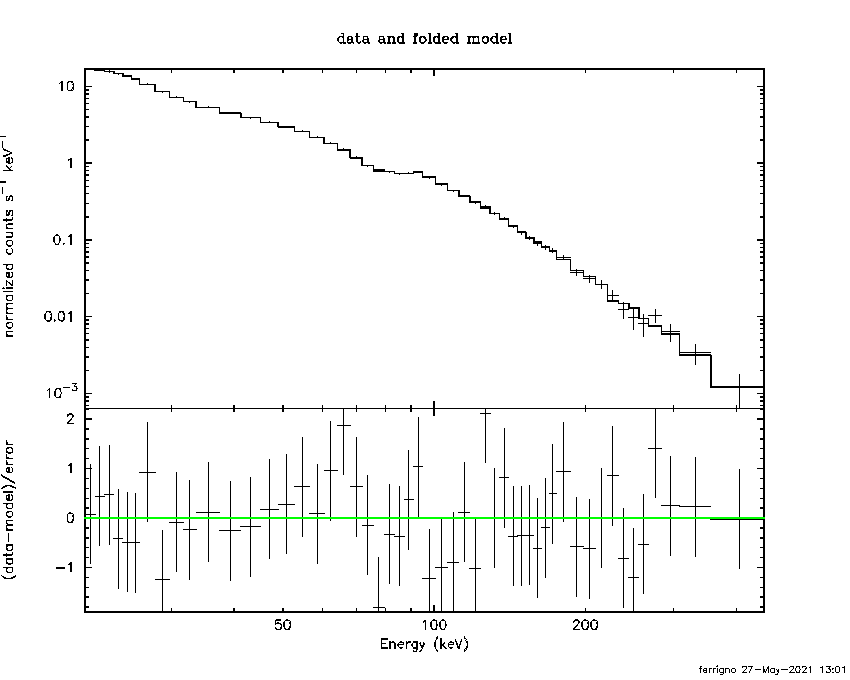

7
ISGRI ignore: **-20.00,500.-**
lg10Flux -7.83 False False
PhoIndx1 2.07 False False
PhoIndx2 2.28 False False


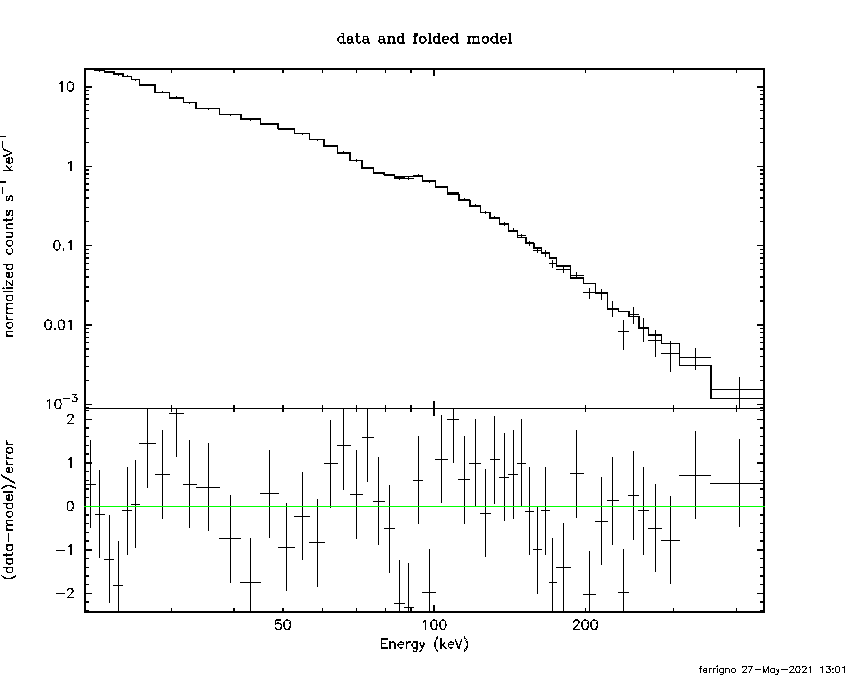

7
ISGRI ignore: **-20.00,500.-**
lg10Flux -7.83 False False
PhoIndx1 2.21 False False
PhoIndx2 2.55 False False


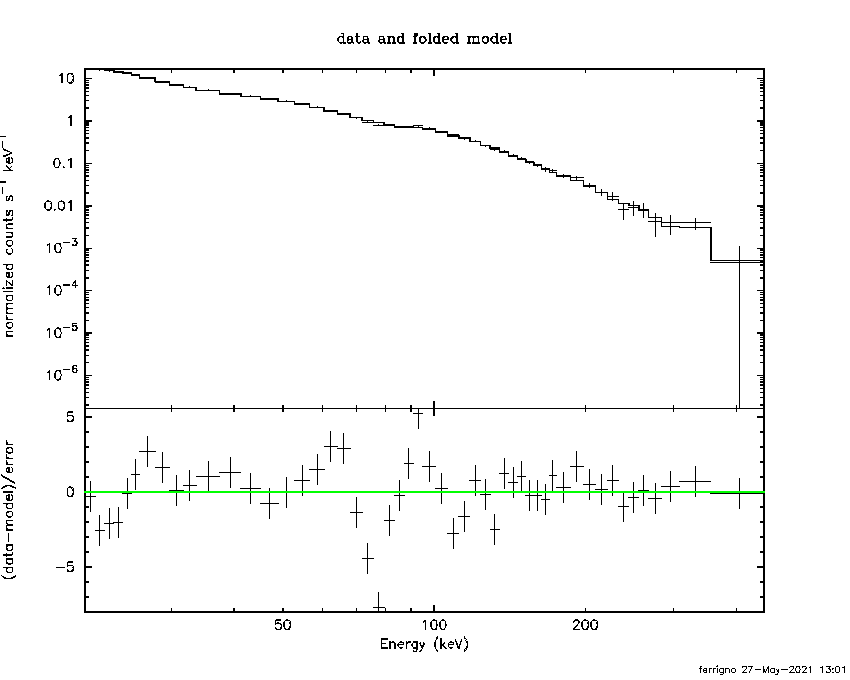

7
ISGRI ignore: **-20.00,500.-**
lg10Flux -7.82 False False
PhoIndx1 2.19 False False
PhoIndx2 2.45 False False


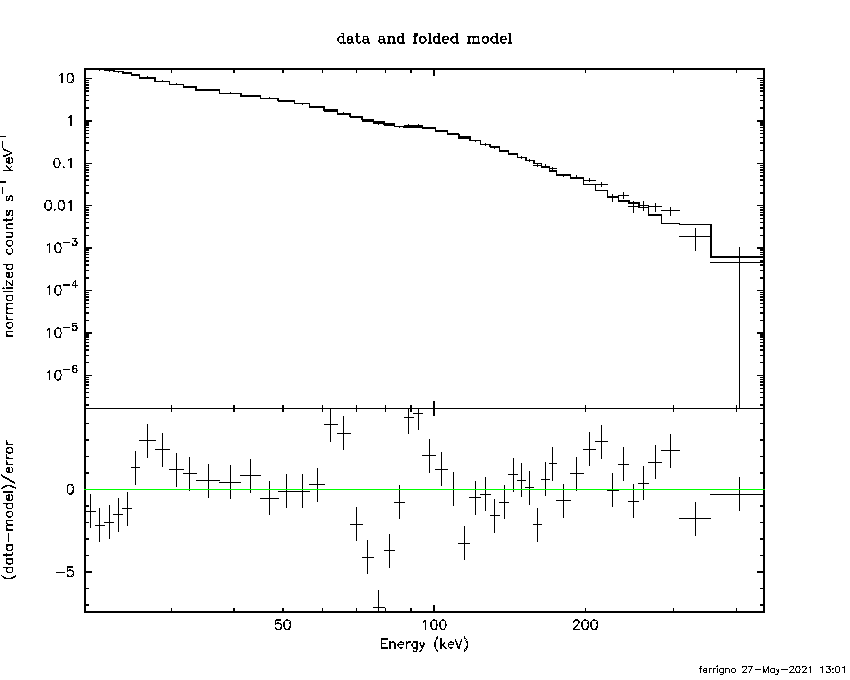

7
ISGRI ignore: **-20.00,500.-**
lg10Flux -7.83 False False
PhoIndx1 2.08 False False
PhoIndx2 2.22 False False


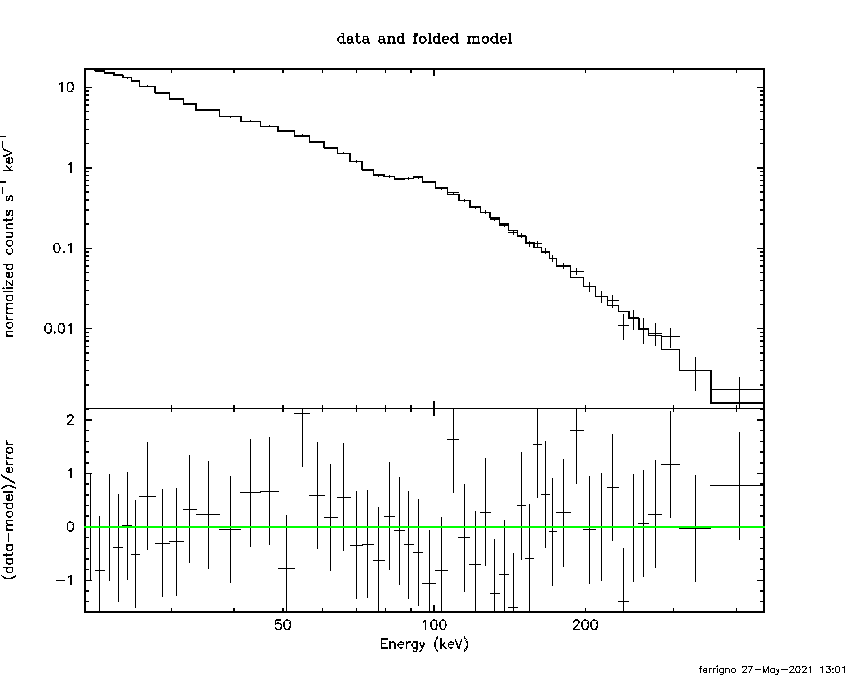

7
ISGRI ignore: **-20.00,500.-**
lg10Flux -7.82 False False
PhoIndx1 2.07 False False
PhoIndx2 2.26 False False


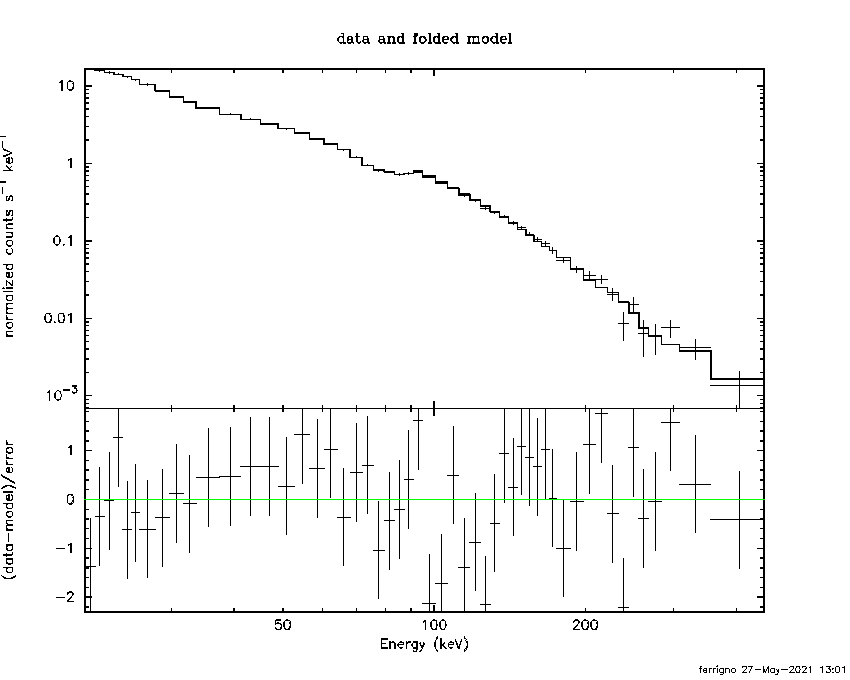

In [14]:
try:

    import xspec
    import shutil
    from IPython.display import Image
    from IPython.display import display 

    xspec.Fit.statMethod = "chi"

    #init dictionaries
    fit_by_lt={}

    model='cflux*bknpow'

    xspec.AllModels.systematic=0.0
    low_energies=[20]
    freeze_pow_ebreak=1

    for year in range(start_year,end_year+1):

        for semester in [1,2]:

            for c_emin in low_energies: #np.linspace(17,40,5):    
                xspec.AllData.clear()

                m1=xspec.Model(model)

                specname=source_name+'_'+str(year)+'_%d'%semester+'_spectrum.fits'

                xspec.AllData(specname)

                s = xspec.AllData(1)

                isgri = xspec.AllModels(1)

                print(m1.nParameters)

                xspec.AllData.ignore('bad')
                xspec.AllData.ignore('500.0-**')

                ig="**-%.2f,500.-**"%c_emin
                print("ISGRI ignore: "+ ig)
                s.ignore(ig)

                #Key for output
                lt_key='%d_%d_%.10lg'%(year,semester, c_emin)

                isgri.cflux.lg10Flux=-8            

                isgri.cflux.Emin=20.
                isgri.cflux.Emax=80.

                isgri.bknpower.norm = "1,-1"
                isgri.bknpower.PhoIndx1 = "2.0,.01,1.,1.,3.,3."
                isgri.bknpower.PhoIndx2 = "2.2,.01,1.,1.,3.,3."
                isgri.bknpower.BreakE = "100,-1,20,20,300,300"

                xspec.Fit.perform()
                isgri.bknpower.BreakE.frozen = freeze_pow_ebreak  > 0

                xspec.Fit.perform()

                max_chi=np.ceil(xspec.Fit.statistic / xspec.Fit.dof)

                xspec.Fit.error("1.0 max %.1f 1-%d"%(max_chi,m1.nParameters))


                fit_by_lt[lt_key]=dict(
                        emin=c_emin,
                        year=year,
                        semester=semester,
                        chi2_red=xspec.Fit.statistic/xspec.Fit.dof,                                
                        chi2=xspec.Fit.statistic,
                        ndof=xspec.Fit.dof,                                    
                    )

                for i in range(1,m1.nParameters+1): 
                    if (not isgri(i).frozen) and (not bool(isgri(i).link)):
                        #use the name plus position because there could be parameters with same name from multiple 
                        #model components (e.g., several gaussians)
                        print(isgri(i).name, "%.2f"%(isgri(i).values[0]), isgri(i).frozen,bool(isgri(i).link) )
                        fit_by_lt[lt_key][isgri(i).name+"_%02d"%(i)]=[ isgri(i).values[0], isgri(i).error[0], isgri(i).error[1] ]



                xspec.Plot.device="/png"
                #xspec.Plot.addCommand("setplot en")
                xspec.Plot.xAxis="keV"
                xspec.Plot("ldata del")
                xspec.Plot.device="/png"

                fn="fit_%s.png"%lt_key
                fit_by_lt[lt_key]['plot_fname'] = fn

                shutil.move("pgplot.png_2", fn)

                _=display(Image(filename=fn,format="png"))

except ImportError:
    print("no problem!")